In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from titanicTransformers import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import seaborn as sns

sns.set_theme()
sns.set_style('white')

In [ ]:
raw = pd.read_csv(r'C:\Users\p.kefalas\Documents\Python\ML\titanic\datasets\titanic.csv')
raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


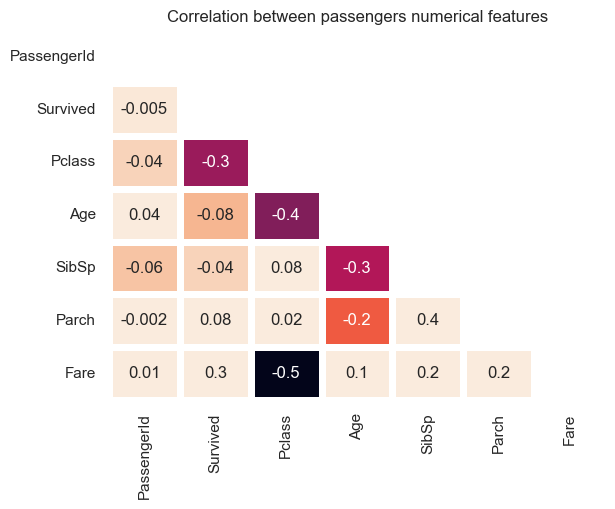

In [ ]:
corrMatrix = raw.corr(numeric_only=True)
corrMask = np.triu(np.ones_like(corrMatrix))

sns.heatmap(corrMatrix, annot=True, fmt=".1g", linewidths=5, mask=corrMask, vmax=0, cbar=False)
plt.title("Correlation between passengers numerical features", fontsize=12)
plt.show()

In [ ]:
X = raw.drop(columns='Survived')
y = raw['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=raw['Pclass'] )

In [ ]:
titanic = raw.iloc[X_train.index, :].copy()
titanic.rename(columns={'Survived':'Survival'}, inplace=True)
titanic['Survived'] = titanic['Survival'].replace([0,1], ['No', 'Yes'])

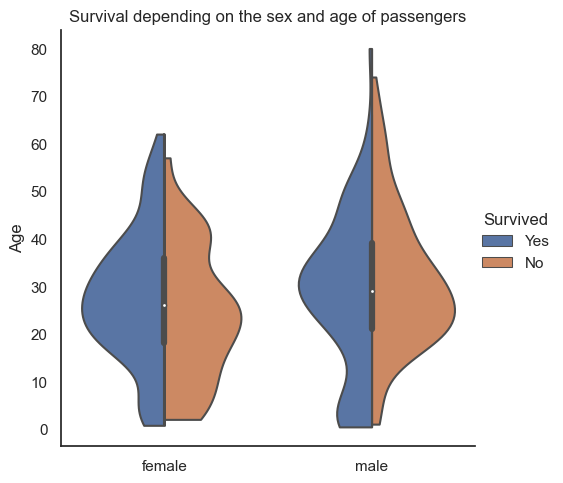

In [ ]:
sns.catplot(data=titanic, x="Sex", y="Age", hue='Survived', kind="violin", hue_order=['Yes','No'], bw=0.35, cut=0, split=True).set(xlabel=None)
plt.title("Survival depending on the sex and age of passengers")
plt.show()

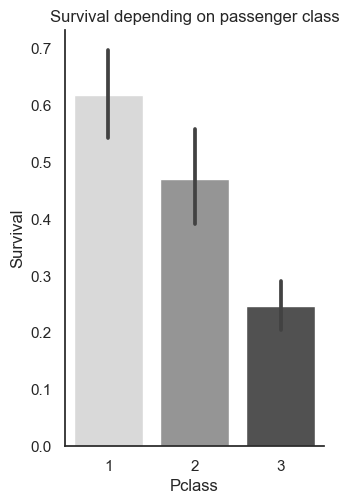

In [ ]:
sns.catplot(kind='bar', data=titanic, x='Pclass', y='Survival', aspect=0.7, palette="Greys")
plt.title("Survival depending on passenger class")
plt.show()

In [ ]:
Xtransformed = transformTitanicDf(X_train)
Xtransformed.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q,S
0,0.0,1.0,0.673285,0.125,0.000000,0.152766,1.0,1.0,0.0,0.0
1,0.5,1.0,0.044986,0.125,0.166667,0.044893,0.0,0.0,0.0,1.0
2,1.0,0.0,0.363498,0.000,0.000000,0.015127,0.0,0.0,1.0,0.0
3,0.5,1.0,0.346569,0.125,0.000000,0.050749,0.0,0.0,0.0,1.0
4,1.0,0.0,0.363498,0.000,0.000000,0.015127,0.0,0.0,1.0,0.0


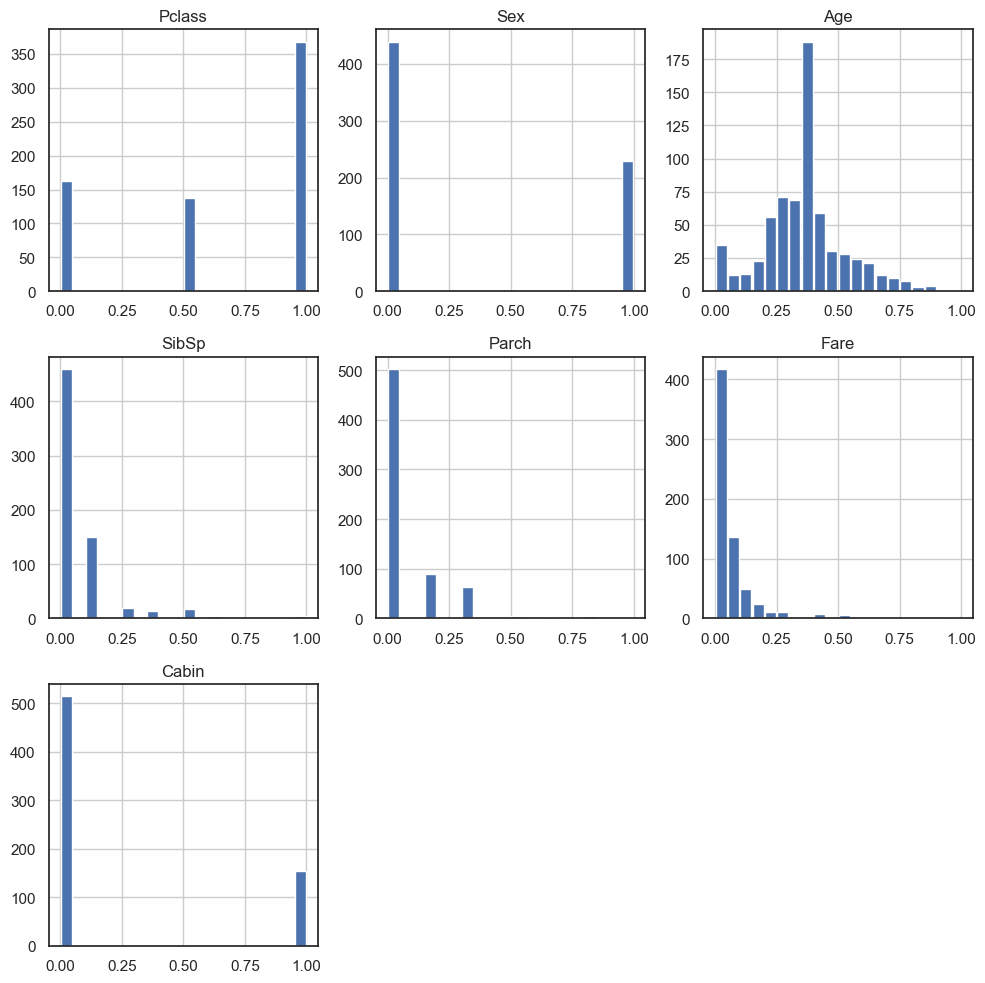

In [ ]:
Xtransformed.iloc[:,:-3].hist(bins=20, figsize=(10,10), rwidth=0.9, zorder=2)
plt.tight_layout()
plt.show()

In [ ]:
Xtransformed.to_csv(r'C:\Users\p.kefalas\Documents\Python\ML\titanic\datasets\titanicTransformed.csv', index=False)
X_train.to_csv(r'C:\Users\p.kefalas\Documents\Python\ML\titanic\datasets\X_train.csv', index=False)
X_test.to_csv(r'C:\Users\p.kefalas\Documents\Python\ML\titanic\datasets\X_test.csv', index=False)
y_train.to_csv(r'C:\Users\p.kefalas\Documents\Python\ML\titanic\datasets\y_train.csv', index=False)
y_test.to_csv(r'C:\Users\p.kefalas\Documents\Python\ML\titanic\datasets\y_test.csv', index=False)


Trying to solve invalid notebook.